# <font color='008fd0'>Overview</font>

This notebooks represents the processing steps for the patient dataset.

## <font color='00b269'>Workflow</font>
- **SimpleTransform** - keep and rename only useful columns
- **TransformDates** - extract age for date and birthdate
- **TransformDiagnostic** - extract diagnostics and comorbidities
- **GroupByPatient** - aggregate rows from the same patient
- **DropNa** - drop nan rows
- **Pandas2Spark** - transform df to spark
- **AppendFilter** - concatenate all dfs
- **Count** - count all patients
- **JoinMeteo** - join with meteo data

In [9]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import holidays
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, recall_score, precision_score, log_loss, roc_auc_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import numpy as np
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
dir = "../../../Data/Patient/DataSet"
target_columns = ['HF', 'RF', 'CI']
df = pd.read_parquet(dir, engine='pyarrow')

# Remove outliers
df = df[(df['Age'] >= 0) & (df['Age'] <= 95)]

# Keep only useful columns
df.drop(columns=['ID', 'Type'], inplace=True)

# Create a class column representing all 4 possible classes: HF, RF, CI, None
df['Class'] = df[target_columns].apply(lambda x: x.idxmax() if x.any() else 'None', axis=1)

print(df.shape)
df.head()


(1566410, 18)


,Date,Sex,Age,HT,AF,CIHD,COPD,VI,HF,RF,CI,Max,Min,Prec,Press,Wind,Insolat,Class
0,2007-02-16,M,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
1,2007-02-16,F,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
2,2007-02-16,F,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
3,2007-02-16,M,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
4,2007-02-16,M,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None


In [3]:
df['Class'].value_counts()

Class
None    1467209
HF        60324
RF        22032
CI        16845
Name: count, dtype: int64

## Pipeline

In [4]:
class BasicTransformations(TransformerMixin):

    def fit(self, X, y=None):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(X['Sex'])
        return self

    def transform(self, df):
        X = df.copy()
        X['Sex'] = self.label_encoder.transform(X['Sex'])
        return X

In [15]:
class DateTransformer(TransformerMixin):
    def __init__(self, day='dayofweek', month=False, holiday=False):
        self.day = day
        self.month = month
        self.holiday = holiday

    def fit(self, X, y=None):
        return self

    def transform(self, df):
        X = df.copy()
        X['Date'] = pd.to_datetime(X['Date']).dt.date

        if self.day == 'dayofweek':
            X['Day'] = X['Date'].apply(lambda x: x.weekday())
        elif self.day == 'weekend':
            X['Weekend'] = X['Date'].apply(lambda x: 1 if x.weekday() >= 4 else 0)
        if self.month:
            X['Month'] = X['Date'].apply(lambda x: x.month)
        if self.holiday:
            min_year = X['Date'].min().year
            max_year = X['Date'].max().year
            holiday = list(holidays.Romania(years=range(min_year, max_year + 1)).keys())
            holiday += [date + pd.Timedelta(days=2) for date in holiday] + [date - pd.Timedelta(days=2) for date in holiday]
            X['Holiday'] = X['Date'].apply(lambda x: 1 if x in holiday else 0)

        X.drop(columns=['Date'], inplace=True)
        return X
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [16]:
class MultiOutputClassifier(BaseEstimator, ClassifierMixin):
    """
    Multi target classifier that uses one classifier per target and undersamples the majority class for each target
    """
    def __init__(self, undersampler=RandomUnderSampler, n_estimators=100, learning_rate=0.1, max_depth=5, min_child_weight=1, specific_hpt=False):
        self.undersampler = undersampler
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.min_child_weight = min_child_weight
        self.classes_ = [0, 1]

        self.specific_hpt = specific_hpt

    def fit(self, X, y):
        target_columns = list(y.columns) if isinstance(y, pd.DataFrame) else y.name
        X, y = check_X_y(X, y, multi_output=True)
        self.estimators_ = [
            XGBClassifier(
                n_estimators=self.n_estimators[i] if self.specific_hpt else self.n_estimators, 
                max_depth=self.max_depth[i] if self.specific_hpt else self.max_depth, 
                learning_rate=self.learning_rate[i] if self.specific_hpt else self.learning_rate, 
                min_child_weight=self.min_child_weight[i] if self.specific_hpt else self.min_child_weight
            ) for i in range(y.shape[1])
        ]

        for i, estimator in enumerate(self.estimators_):
            if self.undersampler:
                sampler = self.undersampler(random_state=42)
                mask = (y[:, i] == 1) | (y.sum(axis=1) == 0)
                X_res, y_res = sampler.fit_resample(X[mask], y[mask][:, i])
                estimator.fit(X_res, y_res)
            else:
                estimator.fit(X, y[:, i])
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        predictions = np.column_stack([estimator.predict(X) for estimator in self.estimators_])
        return predictions
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)

        predictions = np.array([estimator.predict_proba(X) for estimator in self.estimators_])
        return predictions

In [17]:
X = df.drop(target_columns + ['Class'], axis=1)
y = df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=df['Class'])

In [18]:
def evaluate_model(model_, X_test, y_test):
    target_columns = list(y_test.columns) if isinstance(y_test, pd.DataFrame) else list(y_test.name)
    results = {
        'recall': [],
        'precision': [],
        'f1': [],
        'roc_auc': []
    }
    for i, class_ in enumerate(target_columns):
        # keep only the samples that are in the current class or in the None class
        mask = (y_test.iloc[:, i] == 1) | (y_test.sum(axis=1) == 0)
        x_temp, y_temp = X_test[mask], y_test[mask]

        # undersample the majority class in order to evaluate the model
        resampler = RandomUnderSampler(random_state=42)
        X_res, y_res = resampler.fit_resample(x_temp, y_temp.iloc[:, i])
        y_pred = model_.predict(X_res)[:, i]
        y_pred_proba = model_.predict_proba(X_res)[i]

        precision = precision_score(y_res, y_pred)
        recall = recall_score(y_res, y_pred)
        f1 = f1_score(y_res, y_pred)
        roc_auc = roc_auc_score(y_res, y_pred)

        
        print(f"\nClass: {class_}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1 Score: {f1:.3f}")
        print(f"ROC-AUC: {roc_auc:.3f}")
        
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['roc_auc'].append(roc_auc)

    return pd.DataFrame({key: np.mean(value) for key, value in results.items()}, index=target_columns).round(3)

## Heart Failure

### Hyperparameter Tuning

In [19]:
base = Pipeline(steps=[
    ('BasicTransformations', BasicTransformations()),
    ('DateTransformer', DateTransformer(day='weekend', month=True, holiday=True)),
    ('Classifier', MultiOutputClassifier())
])
params = {
    'Classifier__n_estimators': [50, 100, 150],
    'Classifier__learning_rate': [0.005, 0.01, 0.05, 0.1],
    'Classifier__max_depth': [3, 5, 7],
    'Classifier__min_child_weight': [1, 3, 5]
}

search_hf = GridSearchCV(base, params, scoring='recall', cv=4, verbose=1, n_jobs=-1)
search_hf.fit(X_train, y_train[["HF"]])

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('BasicTransformations',
                                        <__main__.BasicTransformations object at 0x7fbf49669840>),
                                       ('DateTransformer',
                                        <__main__.DateTransformer object at 0x7fbf49669f00>),
                                       ('Classifier',
                                        MultiOutputClassifier())]),
             n_jobs=-1,
             param_grid={'Classifier__learning_rate': [0.005, 0.01, 0.05, 0.1],
                         'Classifier__max_depth': [3, 5, 7],
                         'Classifier__min_child_weight': [1, 3, 5],
                         'Classifier__n_estimators': [50, 100, 150]},
             scoring='recall', verbose=1)

In [20]:
scores = search_hf.cv_results_['mean_test_score'].round(2)
params = search_hf.cv_results_['params']

results = pd.DataFrame(params)
results.columns = results.columns.str.split('__').str[-1]
results['recall'] = scores
results.sort_values(by=['recall'], inplace=True, ascending=False)

results.head(10)

,learning_rate,max_depth,min_child_weight,n_estimators,recall
43,0.010,5,5,100,0.94
13,0.005,5,3,100,0.94
36,0.010,5,1,50,0.94
37,0.010,5,1,100,0.94
38,0.010,5,1,150,0.94
39,0.010,5,3,50,0.94
40,0.010,5,3,100,0.94
41,0.010,5,3,150,0.94
42,0.010,5,5,50,0.94
44,0.010,5,5,150,0.94


### Optimized Model

In [27]:
optimized_hf = Pipeline(steps=[
    ('BasicTransformations', BasicTransformations()),
    ('DateTransformer', DateTransformer(day='weekend', month=True, holiday=True)),
    ('Classifier', MultiOutputClassifier(n_estimators=50, max_depth=5, learning_rate=0.01, min_child_weight=5))
])

optimized_hf.fit(X_train, y_train[["HF"]])
evaluate_model(optimized_hf, X_test, y_test[["HF"]])


Class: HF
Precision: 0.754
Recall: 0.941
F1 Score: 0.837
ROC-AUC: 0.817


,recall,precision,f1,roc_auc
HF,0.941,0.754,0.837,0.817


## Respiratory Failure

### Hyperparameter Tuning

In [ ]:
base = Pipeline(steps=[
    ('BasicTransformations', BasicTransformations()),
    ('DateTransformer', DateTransformer(day='weekend', month=True, holiday=True)),
    ('Classifier', MultiOutputClassifier())
])

params = {
    'Classifier__n_estimators': [50, 100, 150],
    'Classifier__learning_rate': [0.005, 0.01, 0.05, 0.1],
    'Classifier__max_depth': [3, 5, 7],
    'Classifier__min_child_weight': [1, 3, 5]
}

search_rf = GridSearchCV(base, params, scoring='recall', cv=4, verbose=1, n_jobs=-1)
search_rf.fit(X_train, y_train[["RF"]])

In [36]:
scores = search_rf.cv_results_['mean_test_score'].round(2)
params = search_rf.cv_results_['params']

results = pd.DataFrame(params)
results.columns = results.columns.str.split('__').str[-1]
results['recall'] = scores
results.sort_values(by=['recall'], inplace=True, ascending=False)

results.head(10)

,learning_rate,max_depth,min_child_weight,n_estimators,recall
107,0.10,7,5,150,0.67
82,0.10,3,1,100,0.67
88,0.10,3,5,100,0.67
87,0.10,3,5,50,0.67
86,0.10,3,3,150,0.67
85,0.10,3,3,100,0.67
84,0.10,3,3,50,0.67
83,0.10,3,1,150,0.67
77,0.05,7,3,150,0.67
91,0.10,5,1,100,0.67


### Optimized Model

In [38]:
optimized_rf = Pipeline(steps=[
    ('BasicTransformations', BasicTransformations()),
    ('DateTransformer', DateTransformer(day='weekend', month=True, holiday=True)),
    ('Classifier', MultiOutputClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, min_child_weight=5))
])

optimized_rf.fit(X_train, y_train[["RF"]])
evaluate_model(optimized_rf, X_test, y_test[["RF"]])


Class: RF
Precision: 0.760
Recall: 0.633
F1 Score: 0.691
ROC-AUC: 0.716


,recall,precision,f1,roc_auc
RF,0.633,0.76,0.691,0.716


## Cerebral Infarction

### Hyperparameter Tuning

In [45]:
base = Pipeline(steps=[
    ('BasicTransformations', BasicTransformations()),
    ('DateTransformer', DateTransformer(day='weekend', month=True, holiday=True)),
    ('Classifier', MultiOutputClassifier())
])

params = {
    'Classifier__n_estimators': [50, 100, 150],
    'Classifier__learning_rate': [0.005, 0.01, 0.05, 0.1],
    'Classifier__max_depth': [3, 5, 7],
    'Classifier__min_child_weight': [1, 3, 5]
}

search_ci = GridSearchCV(base, params, scoring='recall', cv=4, verbose=1, n_jobs=-1)
search_ci.fit(X_train, y_train[["CI"]])

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('BasicTransformations',
                                        <__main__.BasicTransformations object at 0x7fbf7a35cf40>),
                                       ('DateTransformer',
                                        <__main__.DateTransformer object at 0x7fbf7a35c9d0>),
                                       ('Classifier',
                                        MultiOutputClassifier())]),
             n_jobs=-1,
             param_grid={'Classifier__learning_rate': [0.005, 0.01, 0.05, 0.1],
                         'Classifier__max_depth': [3, 5, 7],
                         'Classifier__min_child_weight': [1, 3, 5],
                         'Classifier__n_estimators': [50, 100, 150]},
             scoring='recall', verbose=1)

In [46]:
scores = search_ci.cv_results_['mean_test_score'].round(2)
params = search_ci.cv_results_['params']

results = pd.DataFrame(params)
results.columns = results.columns.str.split('__').str[-1]
results['recall'] = scores
results.sort_values(by=['recall'], inplace=True, ascending=False)

results.head(10)

,learning_rate,max_depth,min_child_weight,n_estimators,recall
1,0.005,3,1,100,0.88
7,0.005,3,5,100,0.88
30,0.010,3,3,50,0.88
33,0.010,3,5,50,0.88
27,0.010,3,1,50,0.88
4,0.005,3,3,100,0.88
58,0.050,3,3,100,0.87
60,0.050,3,5,50,0.87
61,0.050,3,5,100,0.87
81,0.100,3,1,50,0.87


### Optimized Model

In [215]:
optimized_ci = Pipeline(steps=[
    ('BasicTransformations', BasicTransformations()),
    ('DateTransformer', DateTransformer(day='weekend', month=True, holiday=True)),
    ('Classifier', MultiOutputClassifier(n_estimators=50, max_depth=3, learning_rate=0.05, subsample=1))
])

optimized_ci.fit(X_train, y_train[["CI"]])
evaluate_model(optimized_ci, X_test, y_test[["CI"]])


Class: CI


,precision,recall,f1-score,support
0,0.85,0.71,0.77,4211.00
1,0.75,0.87,0.81,4211.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.80,0.79,0.79,8422.00
weighted avg,0.80,0.79,0.79,8422.00


Precision: 0.749
Recall: 0.873
Loss: 0.452
ROC-AUC: 0.864


## Final Model

In [47]:
final = Pipeline(steps=[
    ('BasicTransformations', BasicTransformations()),
    ('DateTransformer', DateTransformer(day='weekend', month=True, holiday=True)),
    ('Classifier', MultiOutputClassifier(n_estimators=[100] * 3, max_depth=[5, 7, 3], learning_rate=[0.01, 0.01, 0.05], min_child_weight=[3, 5, 3], specific_hpt=True))
])

final.fit(X_train, y_train)
evaluate_model(final, X_test, y_test)


Class: HF
Precision: 0.758
Recall: 0.941
F1 Score: 0.840
ROC-AUC: 0.820

Class: RF
Precision: 0.753
Recall: 0.651
F1 Score: 0.699
ROC-AUC: 0.719

Class: CI
Precision: 0.764
Recall: 0.865
F1 Score: 0.811
ROC-AUC: 0.799


,recall,precision,f1,roc_auc
HF,0.819,0.759,0.783,0.779
RF,0.819,0.759,0.783,0.779
CI,0.819,0.759,0.783,0.779


In [210]:
with open('../../Models/FinalPatient.pkl', 'wb') as file:
    pickle.dump(final, file)

## ROC 

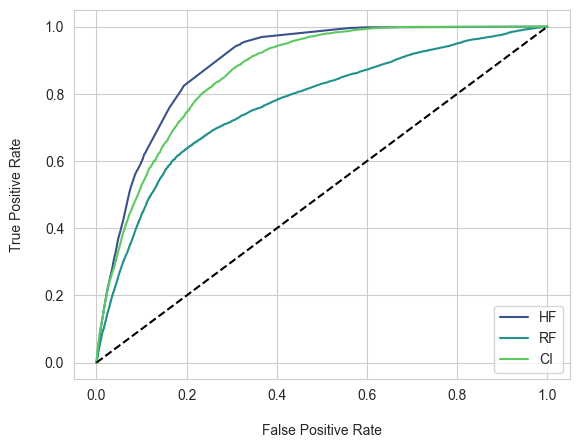

In [49]:
from sklearn.metrics import roc_curve
import seaborn as sns

palette = sns.color_palette("viridis", n_colors=3)
sns.set_style('whitegrid')

for i, target in enumerate(["HF", "RF", "CI"]):
    y_pred = final.predict_proba(X_test)[i, :, 1]
    fpr, tpr, thresholds = roc_curve(y_test[[target]], y_pred)
    sns.lineplot(x=fpr, y=tpr, label=target, color=palette[i])

sns.lineplot(x=[0, 1], y=[0, 1], color='k', linestyle='--')
plt.xlabel('False Positive Rate', labelpad=15)
plt.ylabel('True Positive Rate', labelpad=15)
plt.legend(loc="lower right")
plt.show()